In [1]:
from VariationalBayes import ScalarParam, ModelParamsDict, VectorParam, PosDefMatrixParam
from VariationalBayes.NormalParams import MVNParam, UVNParam, UVNParamVector
from VariationalBayes.GammaParams import GammaParam
from VariationalBayes.ExponentialFamilies import \
    UnivariateNormalEntropy, MultivariateNormalEntropy, GammaEntropy, \
    MVNPrior, UVNPrior, GammaPrior


from autograd import grad, hessian, jacobian, hessian_vector_product
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy as asp
import scipy as sp

import copy
from scipy import optimize

# https://github.com/felixlen/trlib
import trlib

In [2]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.
import os
import json

prior_par = ModelParamsDict('Prior Parameters')

#analysis_name = 'simulated_data_small'
analysis_name = 'simulated_data_large'

data_dir = os.path.join(os.environ['GIT_REPO_LOC'], 'LRVBLogitGLMM/LogitGLMMLRVB/inst/data/')
json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)
json_output_filename = os.path.join(data_dir, '%s_python_vb_results.json' % analysis_name)

json_file = open(json_filename, 'r')
json_dat = json.load(json_file)
json_file.close()

stan_dat = json_dat['stan_dat']
vp_base = json_dat['vp_base']

print stan_dat.keys()
K = stan_dat['K'][0]
NObs = stan_dat['N'][0]
NG = stan_dat['NG'][0]
N = NObs / NG
y_g_vec = np.array(stan_dat['y_group'])
y_vec = np.array(stan_dat['y'])
x_mat = np.array(stan_dat['x'])

# Define a class to contain prior parameters.
prior_par.push_param(VectorParam('beta_prior_mean', K, val=np.array(stan_dat['beta_prior_mean'])))
beta_prior_info = np.linalg.inv(np.array(stan_dat['beta_prior_var']))
prior_par.push_param(PosDefMatrixParam('beta_prior_info', K, val=beta_prior_info))

prior_par.push_param(ScalarParam('mu_prior_mean', val=stan_dat['mu_prior_mean'][0]))
prior_par.push_param(ScalarParam('mu_prior_info', val=1 / stan_dat['mu_prior_var'][0]))

prior_par.push_param(ScalarParam('tau_prior_alpha', val=stan_dat['tau_prior_alpha'][0]))
prior_par.push_param(ScalarParam('tau_prior_beta', val=stan_dat['tau_prior_beta'][0]))

# An index set to make sure jacobians match the order expected by R.
prior_par_indices = copy.deepcopy(prior_par)
prior_par_indices.set_name('Prior Indices')
prior_par_indices.set_vector(np.array(range(prior_par_indices.vector_size())))


[u'y_group', u'mu_prior_var', u'mu_prior_t', u'mu_prior_var_c', u'K', u'beta_prior_var', u'tau_prior_beta', u'N', u'mu_prior_mean_c', u'mu_prior_epsilon', u'mu_prior_mean', u'y', u'x', u'NG', u'beta_prior_mean', u'tau_prior_alpha']


In [3]:
# Build an object to contain a variational approximation to a K-dimensional multivariate normal.
glmm_par = ModelParamsDict('GLMM Parameters')

glmm_par.push_param(ScalarParam('mu'))
glmm_par.push_param(ScalarParam('tau', lb=1e-6))
glmm_par.push_param(VectorParam('beta', K))
glmm_par.push_param(UVNParamVector('u', NG, min_info=vp_base['u_info_min'][0]))

# Initialize with ADVI.  Don't forget to add the ADVI computation time to your final VB time!
advi_fit = json_dat['advi_results']
glmm_par['mu'].set(advi_fit['mu_mean'][0])

tau_mean = advi_fit['tau_mean'][0]
glmm_par['tau'].set(tau_mean)

glmm_par['beta'].set(np.array(advi_fit['beta_mean']))

glmm_par['u'].mean.set(np.array(advi_fit['u_mean']))
glmm_par['u'].info.set(1 / np.array(advi_fit['u_var']))

free_par_vec = glmm_par.get_free()

In [4]:
# Define moment parameters

moment_par = ModelParamsDict('Moment Parameters')
moment_par.push_param(VectorParam('e_beta', K))
moment_par.push_param(PosDefMatrixParam('e_beta_outer', K))
moment_par.push_param(ScalarParam('e_mu'))
moment_par.push_param(ScalarParam('e_mu2'))
moment_par.push_param(ScalarParam('e_tau'))
moment_par.push_param(ScalarParam('e_log_tau'))
moment_par.push_param(VectorParam('e_u', NG))
moment_par.push_param(VectorParam('e_u2', NG))

def set_moments(glmm_par, moment_par):
    e_beta = glmm_par['beta'].get()
    moment_par['e_beta'].set(e_beta)
    moment_par['e_beta_outer'].set(np.outer(e_beta, e_beta))
    moment_par['e_mu'].set(glmm_par['mu'].get())
    moment_par['e_mu2'].set(glmm_par['mu'].get() ** 2)
    moment_par['e_tau'].set(glmm_par['tau'].get())
    moment_par['e_log_tau'].set(np.log(glmm_par['tau'].get()))
    moment_par['e_u'].set(glmm_par['u'].e())
    moment_par['e_u2'].set((glmm_par['u'].e_outer()))
    
set_moments(glmm_par, moment_par)

# Moment indices.
moment_indices = copy.deepcopy(moment_par)
moment_indices.set_vector(1 + np.array(range(moment_indices.vector_size())))

In [5]:
def decode_combined_parameters(combined_free_par_vec, glmm_par, prior_par):
    assert glmm_par.free_size() + prior_par.vector_size() == len(combined_free_par_vec) 
    glmm_par.set_free(combined_free_par_vec[0:glmm_par.free_size()])
    prior_par.set_vector(combined_free_par_vec[glmm_par.free_size():])

    
def encode_combined_parameters(glmm_par, prior_par):
    combined_free_par_vec = np.full(glmm_par.free_size() + prior_par.vector_size(), float('nan'))
    combined_free_par_vec[0:glmm_par.free_size()] = glmm_par.get_free()
    combined_free_par_vec[glmm_par.free_size():] = prior_par.get_vector()
    return combined_free_par_vec


In [6]:
def ELogPrior(prior_par, glmm_par_elbo):
    e_beta = glmm_par_elbo['beta'].get()
    cov_beta = np.zeros((len(e_beta), len(e_beta)))
    beta_prior_info = prior_par['beta_prior_info'].get()
    beta_prior_mean = prior_par['beta_prior_mean'].get()
    e_log_p_beta = MVNPrior(beta_prior_mean, beta_prior_info, e_beta, cov_beta)
    
    e_mu = glmm_par_elbo['mu'].get()
    mu_prior_mean = prior_par['mu_prior_mean'].get()
    mu_prior_info = prior_par['mu_prior_info'].get()
    e_log_p_mu = UVNPrior(mu_prior_mean, mu_prior_info, e_mu, 0.)

    e_tau = glmm_par_elbo['tau'].get()
    e_log_tau = np.log(e_tau)
    tau_prior_shape = prior_par['tau_prior_alpha'].get()
    tau_prior_rate = prior_par['tau_prior_beta'].get()
    e_log_p_tau = GammaPrior(tau_prior_shape, tau_prior_rate, e_tau, e_log_tau)
    
    return  e_log_p_beta + e_log_p_mu + e_log_p_tau
           

def DataLogLikelihood(x_mat, y_vec, e_beta, cov_beta, e_mu, var_mu, e_u, var_u, std_draws):
    z_mean = e_u + e_mu + np.matmul(x_mat, e_beta)
    z_sd = np.sqrt(var_u + var_mu + np.einsum('nk,kj,nj->n', x_mat, cov_beta, x_mat))
    z = np.einsum('i,j->ij', z_sd, std_draws) + np.expand_dims(z_mean, 1)

    # The sum is over observations and draws, so dividing by the draws size
    # gives the sum of sample expectations over the draws.
    # p = exp(z) / (1 + exp(z))
    # log(1 - p) = log(1 / (1 + exp(z))) = -log(1 + exp(z))
    logit_term = -np.sum(np.log1p(np.exp(z))) / std_draws.size
    y_term = np.sum(y_vec * z_mean)
    return y_term + logit_term


def RandomEffectLogLikelihood(e_u, var_u, e_tau, e_log_tau):
    return -0.5 * e_tau * np.sum((e_u ** 2) + var_u) + 0.5 * e_log_tau * len(e_u)

    
def Elbo(y_vec, x_mat, y_g_vec, glmm_par_elbo, std_draws, prior_par):
    e_beta = glmm_par_elbo['beta'].get()
    cov_beta = np.zeros((len(e_beta), len(e_beta)))
    
    e_u = glmm_par_elbo['u'].mean.get()
    info_u = glmm_par_elbo['u'].info.get()
    var_u = 1 / info_u
    
    e_mu = glmm_par_elbo['mu'].get()
    var_mu = 0.
    
    e_tau = glmm_par_elbo['tau'].get()
    e_log_tau = np.log(e_tau)
        
    ll = \
        DataLogLikelihood(x_mat, y_vec, e_beta, cov_beta, e_mu, var_mu,
                          e_u[y_g_vec], var_u[y_g_vec], std_draws) + \
        RandomEffectLogLikelihood(e_u, var_u, e_tau, e_log_tau)
    if np.isnan(ll):
        return -np.inf

    e_log_prior = ELogPrior(prior_par, glmm_par_elbo)
    if np.isnan(e_log_prior):
        return -np.inf
    
    entropy = UnivariateNormalEntropy(info_u)

    return ll[0] + e_log_prior[0] + entropy


class KLWrapper(object):
    def __init__(self, glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_draws):
        self.__glmm_par_ad = copy.deepcopy(glmm_par)
        self.__prior_par_ad = copy.deepcopy(prior_par)
        self.x_mat = x_mat
        self.y_vec = y_vec
        self.y_g_vec = y_g_vec
        draw_spacing = 1 / float(num_draws + 1)
        target_quantiles = np.linspace(draw_spacing, 1 - draw_spacing, num_draws)
        self.std_draws = sp.stats.norm.ppf(target_quantiles)

    def Eval(self, free_par_vec, verbose=False):
        self.__glmm_par_ad.set_free(free_par_vec)
        kl = -Elbo(self.y_vec, self.x_mat, self.y_g_vec,
                   self.__glmm_par_ad, self.std_draws, self.__prior_par_ad)
        if verbose: print kl
            
        # TODO: this is returning an array when it should be a scalar.
        return kl
    
    def ExpectedLogPrior(self, combined_free_par_vec):
        # Encode the glmm parameters first and the prior second.
        decode_combined_parameters(combined_free_par_vec, self.__glmm_par_ad, self.__prior_par_ad)
        e_log_prior = ELogPrior(self.__prior_par_ad, self.__glmm_par_ad)
        return e_log_prior[0]
        

class MomentWrapper(object):
    def __init__(self, glmm_par, moment_par):
        self.__glmm_par_ad = copy.deepcopy(glmm_par)
        self.__moment_par = copy.deepcopy(moment_par)

    # Return a posterior moment of interest as a function of unconstrained parameters.
    def GetMoments(self, free_par_vec):
        self.__glmm_par_ad.set_free(free_par_vec)
        set_moments(self.__glmm_par_ad, self.__moment_par)
        return self.__moment_par.get_vector()
    
    def GetMomentParameters(self, free_par_vec):
        self.__glmm_par_ad.set_free(free_par_vec)
        set_moments(self.__glmm_par_ad, self.__moment_par)
        return self.__moment_par


kl_wrapper = KLWrapper(glmm_par, prior_par, x_mat, y_vec, y_g_vec, 3)
KLGrad = grad(kl_wrapper.Eval)
KLHess = hessian(kl_wrapper.Eval)
KLHessVecProd = hessian_vector_product(kl_wrapper.Eval)  
print kl_wrapper.Eval(free_par_vec)

moment_wrapper = MomentWrapper(glmm_par, moment_par)
MomentJacobian = jacobian(moment_wrapper.GetMoments)

combined_free_par_vec = encode_combined_parameters(glmm_par, prior_par)
PriorHess = hessian(kl_wrapper.ExpectedLogPrior)
kl_wrapper.ExpectedLogPrior(combined_free_par_vec)


1706.69603811


-2.9516013117331994

In [7]:
import timeit

time_num = 10

print 'Function time:'
print timeit.timeit(lambda: kl_wrapper.Eval(free_par_vec), number=time_num) / time_num

print 'Grad time:'
print timeit.timeit(lambda: KLGrad(free_par_vec), number=time_num) / time_num

print 'Hessian vector product time:'
print timeit.timeit(lambda: KLHessVecProd(free_par_vec, free_par_vec + 1), number=time_num) / time_num

# print 'Moment jacobian time:'
# print timeit.timeit(lambda: MomentJacobian(free_par_vec), number=time_num) / time_num

# time_num = 1
# print 'Prior Hessian time:'
# print timeit.timeit(lambda: PriorHess(combined_free_par_vec), number=time_num) / time_num

# # so slow
# print 'Hessian time:'
# print timeit.timeit(lambda: KLHess(free_par_vec), number=time_num) / time_num


Function time:
0.0191396951675
Grad time:
0.0200529098511
Hessian vector product time:
0.0278309106827


In [8]:
x_opt = trlib.umin(lambda par: kl_wrapper.Eval(par, verbose=False), KLGrad, KLHessVecProd, free_par_vec, itmax=50)

it   obj         ‖g‖        radius     step       rho          ?  nhv
   0 +1.7067e+03 3.0816e+02 3.1204e-02 3.1204e-02 +1.0000e+00  +    3
   1 +1.6973e+03 2.9131e+02 6.2409e-02 6.2409e-02 +9.9999e-01  +    3
   2 +1.6802e+03 2.5847e+02 1.2482e-01 1.2482e-01 +9.9959e-01  +    4
   3 +1.6519e+03 1.9634e+02 2.4963e-01 2.4963e-01 +9.9367e-01  +    6
   4 +1.6170e+03 8.8192e+01 4.9927e-01 4.9927e-01 +9.8318e-01  +   12
   5 +1.6020e+03 1.1021e+01 9.9854e-01 9.9854e-01 +1.0001e+00  +   14
   6 +1.5925e+03 9.0798e+00 1.9971e+00 1.9971e+00 +9.9847e-01  +   17
   7 +1.5757e+03 7.8324e+00 3.9942e+00 3.9942e+00 +9.9391e-01  +   27
   8 +1.5496e+03 6.6791e+00 7.9883e+00 7.9883e+00 +1.0130e+00  +   46
   9 +1.5214e+03 8.4913e+00 1.5977e+01 1.1336e+01 +8.9102e-01  +   68
  10 +1.5116e+03 5.8132e+00 1.5977e+01 1.9237e+00 +9.8639e-01  +   61
  11 +1.5111e+03 2.4196e-01 3.1953e+01 7.0281e-02 +1.0003e+00  +   53
  12 +1.5111e+03 1.0434e-03 6.3906e+01 1.7474e-04 +9.9941e-01  +   39
  13 +1.5111e+03 1.2

In [9]:
h_opt = KLHess(x_opt)

In [10]:
e_vals, e_vecs = np.linalg.eig(h_opt)

In [11]:
print np.min(e_vals)
print np.max(e_vals)
g_opt = KLGrad(x_opt)
print np.linalg.norm(np.linalg.solve(h_opt, g_opt))
x_newt = x_opt - np.linalg.solve(h_opt, g_opt)
print '---------'
print kl_wrapper.Eval(x_opt)
print kl_wrapper.Eval(x_newt)
print np.linalg.norm(KLGrad(x_newt))
print np.linalg.norm(KLGrad(x_opt))
print np.dot(KLGrad(x_opt), KLGrad(x_newt))

0.202043430458
606.882312829
9.14566200798e-09
---------
1511.08478202
1511.08478202
1.36366631712e-13
1.28777372451e-08
2.51044788596e-23


In [12]:
glmm_par_opt = copy.deepcopy(glmm_par)
glmm_par_opt.set_free(x_opt)
set_moments(glmm_par_opt, moment_par)
print glmm_par_opt
print moment_par

GLMM Parameters:
	mu: [-0.532391]
	tau: [ 0.41434902]
	beta:
[ 0.09939193 -0.13487436  0.21736758  0.22261582  0.27435837  0.32138226
  0.26533087  0.35295883  0.35121595  0.44882516  0.4633918   0.51108483
  0.5203317   0.69948963  0.71561398  0.69252692  0.73700423  0.77626552
  0.88740017  0.99155928  0.82720238  0.88137723  1.02295829  1.02430555
  0.91302036]
	u:
u_mean:
[ 2.00708942 -0.60097552  0.93097284  0.48482606  0.3961035   1.18435671
  1.12150184  0.77357093  2.07150316 -0.86943182  1.56350208  2.1861528
 -1.78126283 -0.70867157 -1.16864323 -0.13125284 -1.05295591 -2.51204379
 -0.761823    1.61441246 -0.3225367  -0.7842134  -0.536597    1.2078664
  1.10248277 -1.20301726 -1.80749434 -0.40459914 -2.47286976  0.21237799
 -0.53190991  1.18386815  0.74184404 -0.62154384  0.35053192 -1.48456971
 -0.95436727 -1.52630653 -1.78925318 -0.53370469  0.53985203 -0.48096191
  1.64944986 -0.32417322 -0.16727658  0.21877008 -1.16229018  0.79037236
  0.44040814  0.90835247  0.2288051  -0

In [13]:
# print vp_indices

eps = 0.5
def get_grid(ind):
    return np.arange(x_opt[ind] - eps * g_opt[ind], x_opt[ind] + eps * g_opt[ind], eps * g_opt[ind] / 7)

ind1 = 0
ind2 = 1
grid1 = get_grid(ind1)
grid2 = get_grid(ind2)

x = copy.deepcopy(x_opt)
def kl_x12(x1, x2):
    x[ind1] = x1
    x[ind2] = x2
    return kl_wrapper.Eval(x)

f = [ [ kl_x12(x1, x2) for x1 in grid1] for x2 in grid2 ]


In [14]:
import matplotlib.pyplot as plt
plt.matshow(f)
plt.colorbar()

plt.plot(len(grid1) / 2., len(grid2) / 2., 'ro')
plt.plot(50 * g_opt[ind1] + len(grid1) / 2., 50 * g_opt[ind2] + len(grid2) / 2., 'ro')
print g_opt[ind1]
print g_opt[ind2]

2.26028973316e-10
6.10775308092e-10


1.63128903966e-13
3.63797880709e-06


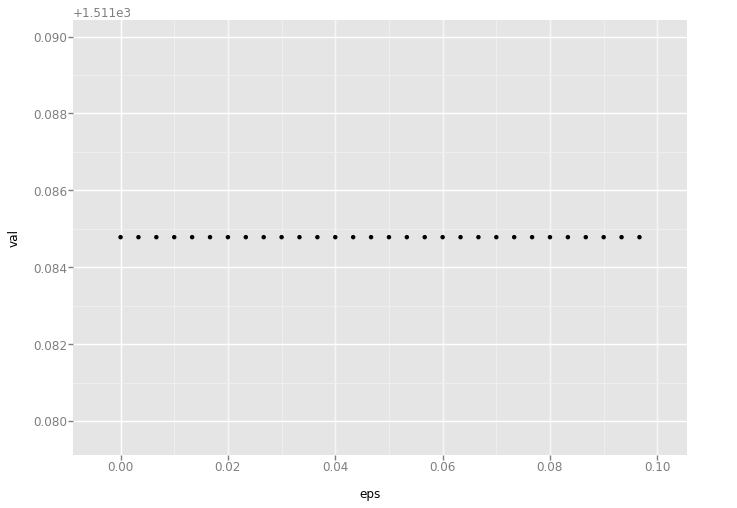

<ggplot: (8754814325965)>


In [15]:

g_opt = KLGrad(x_opt)
x = copy.deepcopy(x_opt) - 0.25 * g_opt

g = KLGrad(x)
print np.linalg.norm(g) ** 2
eps = 1e-6
print (kl_wrapper.Eval(x - eps * g) - kl_wrapper.Eval(x)) / eps


from ggplot import *
import pandas as pd
%matplotlib inline

max_eps = 0.1
eps_vals = np.arange(0., max_eps, max_eps / 30)
kl_steps = [ kl_wrapper.Eval(x - eps * g) for eps in eps_vals ]
plot_df = pd.DataFrame({ 'eps': eps_vals, 'val': kl_steps })
print ggplot(plot_df, aes(x='eps', y='val')) + geom_point()


In [16]:
gnew = KLGrad(x - 0.05 * g)
print np.linalg.norm(g)
print np.linalg.norm(gnew)
print np.linalg.norm(gnew[:27])
print np.linalg.norm(gnew[27:])
print np.linalg.norm(gnew - g)

vp_indices = copy.deepcopy(glmm_par)
vp_indices.set_vector(1 + np.array(range(vp_indices.vector_size())))

# print vp_indices

for i in range(len(g)):
    print '%d: %0.4f, %0.4f, %0.4f' % (i, g[i], gnew[i], gnew[i] - g[i])

4.03892193495e-07
5.40470635263e-06
5.40220805757e-06
1.64313301128e-07
5.77528695833e-06
0: 0.0000, -0.0000, -0.0000
1: -0.0000, 0.0000, 0.0000
2: 0.0000, -0.0000, -0.0000
3: 0.0000, -0.0000, -0.0000
4: 0.0000, -0.0000, -0.0000
5: -0.0000, 0.0000, 0.0000
6: 0.0000, -0.0000, -0.0000
7: -0.0000, 0.0000, 0.0000
8: 0.0000, -0.0000, -0.0000
9: 0.0000, -0.0000, -0.0000
10: 0.0000, -0.0000, -0.0000
11: 0.0000, -0.0000, -0.0000
12: 0.0000, -0.0000, -0.0000
13: -0.0000, 0.0000, 0.0000
14: 0.0000, -0.0000, -0.0000
15: 0.0000, -0.0000, -0.0000
16: -0.0000, 0.0000, 0.0000
17: 0.0000, -0.0000, -0.0000
18: 0.0000, -0.0000, -0.0000
19: 0.0000, -0.0000, -0.0000
20: 0.0000, -0.0000, -0.0000
21: -0.0000, 0.0000, 0.0000
22: 0.0000, -0.0000, -0.0000
23: 0.0000, -0.0000, -0.0000
24: 0.0000, -0.0000, -0.0000
25: 0.0000, -0.0000, -0.0000
26: 0.0000, -0.0000, -0.0000
27: -0.0000, 0.0000, 0.0000
28: 0.0000, -0.0000, -0.0000
29: -0.0000, 0.0000, 0.0000
30: 0.0000, -0.0000, -0.0000
31: -0.0000, -0.0000, -0.0000

In [17]:
import time

class OptimizationPath(object):
    def __init__(self):
        self.x_history = []
        pass
    
    def save(self, x):
        self.x_history.append(x)

bfgs_path = OptimizationPath()
init_par_vec = copy.deepcopy(free_par_vec)

# Optimize.
vb_time = time.time()
# print 'Running BFGS'
# vb_opt_bfgs = optimize.minimize(
#     lambda par: kl_wrapper.Eval(par, verbose=True), init_par_vec,
#     method='bfgs', jac=KLGrad, tol=1e-2, callback=bfgs_path.save,
#     options={'maxiter': 100, 'gtol': 1e-2, 'disp': True})

trust_path = OptimizationPath()
print 'Running Newton Trust Region'
# trust_init = copy.deepcopy(vb_opt_bfgs.x)
trust_init = copy.deepcopy(init_par_vec)
vb_opt = optimize.minimize(
    lambda par: kl_wrapper.Eval(par, verbose=True),
    trust_init, method='trust-ncg', jac=KLGrad, hessp=KLHessVecProd,
    tol=1e-6, callback=trust_path.save,
    options={'maxiter': 100, 'disp': True, 'gtol': 1e-6, 'eta': 0.15 })

vb_time = time.time() - vb_time

glmm_par_opt = copy.deepcopy(glmm_par)
glmm_par_opt.set_free(vb_opt.x)

print 'Done.'

print vb_time / 60

Running Newton Trust Region
1706.69603811
1619.04902005
1608.33313673
1606.45956506
1599.01238586
1596.31264219
1581.19596575
1578.47140029
1555.86228103
1551.64164915
1526.10394091
1524.8274527
1524.68995118
1512.92262071
1512.81410077
1511.63092327
1511.09371761
1511.08774178
1511.08492163
1511.08478289
1511.08478202
1511.08478202
Optimization terminated successfully.
         Current function value: 1511.084782
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
         Hessian evaluations: 0
Done.
0.0989667137464


In [18]:
print len(trust_path.x_history)

# for i in range(len(path.x_history) - 1):
#     print np.sum(path.x_history[i + 1] - path.x_history[i])
    
# for i in range(len(trust_path.x_history)):
#     glmm_par.set_free(trust_path.x_history[i])
#     #print 'Iteration ' + str(i) + '\n'
#     #print str(np.diag(glmm_par['beta'].info.get())) + '\n'
#     #print str(np.diag(glmm_par['mu'].get())) + '\n'
#     #print str(glmm_par['beta'].get()[2]) + '\n'

vals = [ kl_wrapper.Eval(x) for x in trust_path.x_history ]

# for i in range(len(trust_path.x_history)):
    #grad = KLGrad(trust_path.x_history[i])
    #print np.max(np.abs(grad))

# print vals



21


In [19]:
hess = KLHess(vb_opt.x)

In [20]:
vals, vecs = np.linalg.eig(hess)
grad = KLGrad(vb_opt.x)
step_direction = -np.linalg.solve(hess, grad)

In [21]:
# Get the conjugate gradient step direction

from scipy.sparse.linalg import LinearOperator

ObjHessVecProdLO = LinearOperator((vb_opt.x.size, vb_opt.x.size), lambda par: KLHessVecProd(vb_opt.x, par))
cg_step_direction, info = sp.sparse.linalg.cg(ObjHessVecProdLO, -grad)
assert info == 0
print np.max(np.abs(cg_step_direction - step_direction))


7.83247960427e-08


In [22]:
# Check the random effect estimates.  This requires simulated data.
from ggplot import *
import pandas as pd
%matplotlib inline

# plot_df = pd.DataFrame({ 'iter': np.arange(len(vals)), 'val': np.log10(np.abs(vals)) })
# print ggplot(plot_df[30:], aes(x='iter', y='val')) + geom_point()



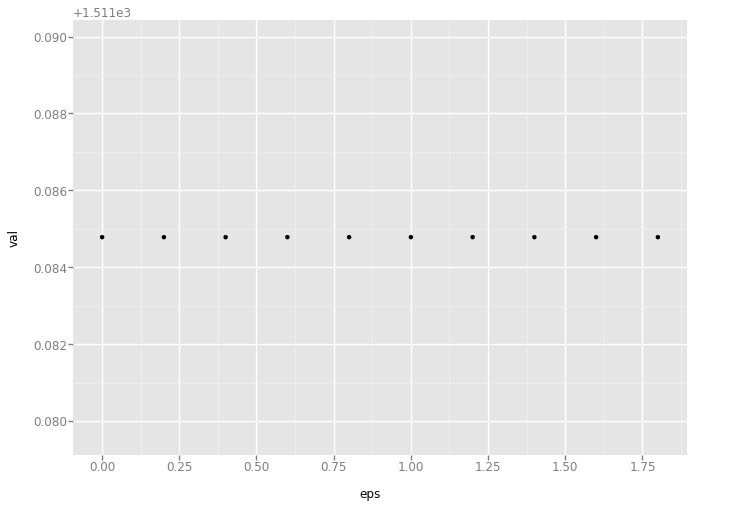

<ggplot: (8754814234693)>
0.0
0.0


In [23]:
max_eps = 2.
eps_vals = np.arange(0., max_eps, max_eps / 10)
kl_steps = [ kl_wrapper.Eval(vb_opt.x + eps * cg_step_direction) for eps in eps_vals ]
plot_df = pd.DataFrame({ 'eps': eps_vals, 'val': kl_steps })
print ggplot(plot_df, aes(x='eps', y='val')) + geom_point()

print (kl_steps[0] - np.min(kl_steps)) / kl_steps[0]
print kl_steps[0] - np.min(kl_steps)

# glmm_par.set_free(step_direction / np.linalg.norm(step_direction))
# min_vec = vecs[:, vals.argmin()]
# glmm_par.set_free(min_vec)
# print glmm_par

0.0
1.72644268332e-07
2.37209101736e-07
4.23142554456e-05


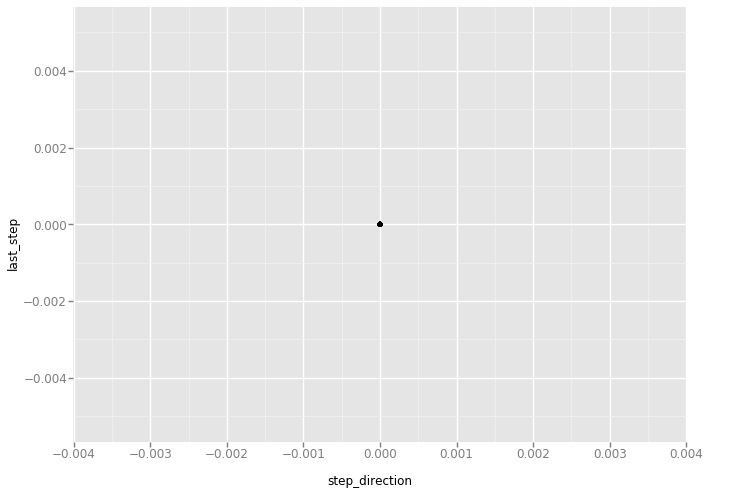

<ggplot: (8754814284857)>


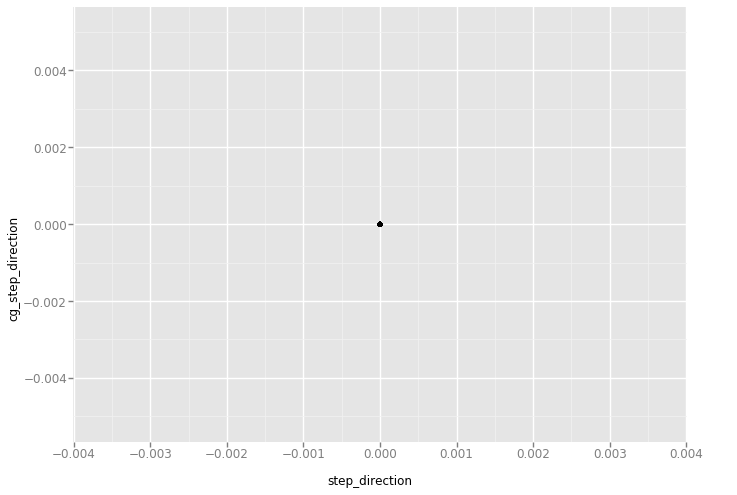

<ggplot: (8754818763693)>
0.747809152872
1.0


In [24]:
last_step = trust_path.x_history[len(trust_path.x_history) - 1] - trust_path.x_history[len(trust_path.x_history) - 2]

print np.linalg.norm(cg_step_direction)
print np.linalg.norm(step_direction)
print np.linalg.norm(grad)
print np.linalg.norm(last_step)

plot_df = pd.DataFrame({ 'last_step': last_step, 'step_direction': step_direction })
print ggplot(plot_df, aes(x='step_direction', y='last_step')) + geom_point()

plot_df = pd.DataFrame({ 'cg_step_direction': cg_step_direction, 'step_direction': step_direction })
print ggplot(plot_df, aes(x='step_direction', y='cg_step_direction')) + geom_point()

print np.sum(np.abs(last_step) < 1e-6) / float(len(last_step))
print np.sum(np.abs(step_direction) < 1e-6) / float(len(step_direction))


In [25]:
# Slow, but probably faster than using CG.
combined_free_par_vec = encode_combined_parameters(glmm_par_opt, prior_par)

hess_time = time.time()
print 'KL Hessian.\n'
kl_hess = KLHess(vb_opt.x)
print 'Log prior Hessian.\n'
log_prior_hess_full = PriorHess(combined_free_par_vec)
hess_time =  time.time() - hess_time
elbo_hess = -kl_hess

print 'hess_time: %f' % hess_time

KL Hessian.

Log prior Hessian.

hess_time: 10.570055


In [26]:
glmm_inds = range(glmm_par_opt.free_size())
prior_inds = range(glmm_par_opt.free_size(), len(combined_free_par_vec))
log_prior_hess = log_prior_hess_full[np.ix_(prior_inds, glmm_inds)]

moment_jac = MomentJacobian(vb_opt.x)
lrvb_cov = np.matmul(moment_jac, np.linalg.solve(kl_hess, moment_jac.T))

prior_indices = copy.deepcopy(prior_par)
prior_indices.set_vector(1 + np.array(range(prior_indices.vector_size())))

vp_indices = copy.deepcopy(glmm_par_opt)
vp_indices.set_vector(1 + np.array(range(vp_indices.vector_size())))

In [27]:
run_name = 'debug'
result_dict = { 'glmm_par_opt': glmm_par_opt.dictval(), 'run_name': run_name,
                'vb_time': vb_time,'hess_time': hess_time, 
                'moment_indices': moment_indices.dictval(),
                'prior_indices': prior_indices.dictval(),
                'vp_indices': vp_indices.dictval(),
                'lrvb_cov': lrvb_cov.tolist(), 'moment_jac': moment_jac.tolist(),
                'elbo_hess': elbo_hess.tolist(), 'log_prior_hess': log_prior_hess.tolist() }

result_json = json.dumps(result_dict)
json_file = open(json_output_filename, 'w')
json_file.write(result_json)
json_file.close()

print(json_output_filename)

/home/rgiordan/Documents/git_repos/LRVBLogitGLMM/LogitGLMMLRVB/inst/data/simulated_data_large_python_vb_results.json
